In [1]:
!pip install pdfplumber
!pip install camelot-py[cv]
!pip install --upgrade pymupdf
!pip install google-generativeai
!pip install faiss-cpu
!pip install transformers tqdm pandas pytesseract pillow easyocr langchain langchain-community langchain_openai faiss-cpu rank_bm25 pdf2image
!pip install sentence_transformers
!pip install python-dotenv

zsh:1: no matches found: camelot-py[cv]
  Using cached pymupdf-1.26.6-cp310-abi3-macosx_11_0_arm64.whl.metadata (3.4 kB)
Using cached pymupdf-1.26.6-cp310-abi3-macosx_11_0_arm64.whl (22.5 MB)
  Attempting uninstall: pymupdf
    Found existing installation: PyMuPDF 1.26.5
    Uninstalling PyMuPDF-1.26.5:
      Successfully uninstalled PyMuPDF-1.26.5


In [1]:
from dotenv import load_dotenv
import re
import os, glob
import pdfplumber
import camelot
import pymupdf
import numpy as np
import pandas as pd
from pathlib import Path
import time
import faiss, json
import collections
import fitz
import io
from PIL import Image
import pytesseract
from langchain_core.documents import Document
from openai import OpenAI
from TableRetrieval.table_ingestion import stage1_extract_and_save
from TableRetrieval.table_ingestion import store_in_faiss, save_metadata_mapping
from TableRetrieval.table_agentic_rag import TableAgenticRAG

load_dotenv()

True

# Agent CFO — Performance Optimization & Design

---
This is the starter notebook for your project. Follow the required structure below.


You will design and optimize an Agent CFO assistant for a listed company. The assistant should answer finance/operations questions using RAG (Retrieval-Augmented Generation) + agentic reasoning, with response time (latency) as the primary metric.

Your system must:
*   Ingest the company’s public filings.
*   Retrieve relevant passages efficiently.
*   Compute ratios/trends via tool calls (calculator, table parsing).
*   Produce answers with valid citations to the correct page/table.


## 1. Config & Secrets

Fill in your API keys in secrets. **Do not hardcode keys** in cells.

In [2]:
import os

# Example:
# os.environ['GEMINI_API_KEY'] = 'your-key-here'
# os.environ['OPENAI_API_KEY'] = 'your-key-here'

COMPANY_NAME = "Google"

CHUNK_SIZE = 500  # number of words per chunk 

def generate_test_log_path_name(base_path: str): 
    # create the directory if not exist 
    os.makedirs(base_path, exist_ok=True) 
    existing_files = [f for f in os.listdir(base_path) if f.startswith("test_") and f.endswith(".json")] 
    existing_indices = [int(f.split("_")[1].split(".")[0]) for f in existing_files if f.split("_")[1].split(".")[0].isdigit()] 
    next_index = max(existing_indices) + 1 if existing_indices else 1 

    return f"{base_path}/test_{next_index}.json"


## 2. Data Download (Dropbox)

*   Annual Reports: last 3–5 years.
*   Quarterly Results Packs & MD&A (Management Discussion & Analysis).
*   Investor Presentations and Press Releases.
*   These files must be submitted later as a deliverable in the Dropbox data pack.
*   Upload them under `/content/data/`.

Scope limit: each team will ingest minimally 15 PDF files total.


In [3]:
DATA_DIR = "00-data"

# Annual reports (10-Ks)
annual_files = glob.glob(f"{DATA_DIR}/annuals/*.pdf")

# # Quarterly reports (10-Qs)
quarterly_files = glob.glob(f"{DATA_DIR}/quarterlies/*.pdf")

# Presentations
presentation_files = glob.glob(f"{DATA_DIR}/presentations/*.pdf")

In [4]:
for folder in ["annuals", "quarterlies", "presentations"]:

    files = glob.glob(f"{DATA_DIR}/{folder}/*.pdf")
    print(f"{folder}: {len(files)} files")

annuals: 3 files
quarterlies: 11 files
presentations: 2 files


## 3. System Requirements

**Retrieval & RAG**
*   Use a vector index (e.g., FAISS, LlamaIndex) + a keyword filter (BM25/ElasticSearch).
*   Citations must include: report name, year, page number, section/table.

**Agentic Reasoning**
*   Support at least 3 tool types: calculator, table extraction, multi-document compare.
*   Reasoning must follow a plan-then-act pattern (not a single unstructured call).

**Instrumentation**
*   Log timings for: T_ingest, T_retrieve, T_rerank, T_reason, T_generate, T_total.
*   Log: tokens used, cache hits, tools invoked.
*   Record p50/p95 latencies.

### Embeddings

In [5]:
def create_embeddings(chunks, model="text-embedding-3-small"):
    """
    Create embeddings for chunks using OpenAI.
    Returns: chunks with 'embedding' field added
    """
    print(f"Creating embeddings with {model}...\n")
    print(f"   Total chunks: {len(chunks)}")
    
    client = OpenAI()

    # Split into batches of 50
    batch_size = 50
    total_batches = (len(chunks) + batch_size - 1) // batch_size

    for i in range(0, len(chunks), batch_size):
        batch = chunks[i:i + batch_size]
        batch_num = i // batch_size + 1
        print(f"   Processing batch {batch_num} of {total_batches}...")

        contents = [chunk['content'] for chunk in batch]
        
        # Embed batch
        response = client.embeddings.create(
            model=model,
            input=contents
        )
        
        # Add embeddings to chunks
        for j, chunk in enumerate(batch):
            chunk['embedding'] = response.data[j].embedding

        # Small delay to respect rate limits
        if i + batch_size < len(chunks):
                time.sleep(0.6) # Adjust as needed
    
    print(f"Created {len(chunks)} embeddings\n")
    return chunks

### Table Ingestion

In [8]:
def stage2_create_embeddings(json_file):
    """
    Load extracted tables from JSON and create embeddings.
    This is where you spend OpenAI tokens.
    """
    load_dotenv()
    
    DATA_DIR = "00-data"
    
    print("="*80)
    print("STAGE 2: CREATING EMBEDDINGS")
    print("="*80)
    print()
    
    # Load the extracted tables
    print(f"Loading: {json_file}")
    with open(json_file, 'r') as f:
        table_chunks = json.load(f)
    
    print(f"Loaded {len(table_chunks)} tables")
    
    print("\nCreating embeddings...")
    embedded_chunks = create_embeddings(table_chunks)
    
    print("\nStoring in FAISS...")
    faiss_index = store_in_faiss(
        embedded_chunks,
        faiss_index_path=f"{DATA_DIR}/base/faiss_table_index"
    )
    
    print("\nSaving metadata...")
    save_metadata_mapping(
        embedded_chunks,
        mapping_path=f"{DATA_DIR}/base/faiss_table_metadata.json"
    )
    
    print(f"\n{'='*80}")
    print("COMPLETE!")
    print("="*80)
    print(f"FAISS index: {DATA_DIR}/base/faiss_table_index")
    print(f"Metadata: {DATA_DIR}/base/faiss_table_metadata.json")
    print()

In [9]:
# Insert table ingestion code here
stage1_extract_and_save()

STAGE 1: EXTRACTING TABLES FROM PDFs


annuals: 3 files
  Processing: 00-data/annuals\goog-10-k-2022.pdf
    → Extracted 76 tables
  Processing: 00-data/annuals\goog-10-k-2023-final.pdf
    → Extracted 69 tables
  Processing: 00-data/annuals\goog-10-k-2024.pdf
    → Extracted 69 tables

quarterlies: 11 files
  Processing: 00-data/quarterlies\goog-10-q-q1-2022.pdf
    → Extracted 66 tables
  Processing: 00-data/quarterlies\goog-10-q-q1-2023.pdf
    → Extracted 70 tables
  Processing: 00-data/quarterlies\goog-10-q-q1-2024.pdf
    → Extracted 65 tables
  Processing: 00-data/quarterlies\goog-10-q-q1-2025.pdf
    → Extracted 78 tables
  Processing: 00-data/quarterlies\goog-10-q-q2-2022.pdf
    → Extracted 71 tables
  Processing: 00-data/quarterlies\goog-10-q-q2-2023.pdf
    → Extracted 75 tables
  Processing: 00-data/quarterlies\goog-10-q-q2-2024.pdf
    → Extracted 81 tables
  Processing: 00-data/quarterlies\goog-10-q-q2-2025.pdf
    → Extracted 86 tables
  Processing: 00-data/quarterlies\

('00-data/extracted_tables.json', 1036)

In [9]:
stage2_create_embeddings(f"{DATA_DIR}/extracted_tables.json")

STAGE 2: CREATING EMBEDDINGS

Loading: 00-data/extracted_tables.json
Loaded 1036 tables

Creating embeddings...
Creating embeddings with text-embedding-3-small...

   Total chunks: 1036
   Processing batch 1 of 21...
   Processing batch 2 of 21...
   Processing batch 3 of 21...
   Processing batch 4 of 21...
   Processing batch 5 of 21...
   Processing batch 6 of 21...
   Processing batch 7 of 21...
   Processing batch 8 of 21...
   Processing batch 9 of 21...
   Processing batch 10 of 21...
   Processing batch 11 of 21...
   Processing batch 12 of 21...
   Processing batch 13 of 21...
   Processing batch 14 of 21...
   Processing batch 15 of 21...
   Processing batch 16 of 21...
   Processing batch 17 of 21...
   Processing batch 18 of 21...
   Processing batch 19 of 21...
   Processing batch 20 of 21...
   Processing batch 21 of 21...
Created 1036 embeddings


Storing in FAISS...
Stored 1036 vectors in FAISS index at '00-data/base/faiss_table_index'


Saving metadata...
Saved metadat

### Slides Ingestion

In [10]:
from ImageRetrieval.ImageRetrieval import ImageRetriever
from ImageRetrieval.slides_extractor import extract_slides_fitz
from ImageRetrieval.ocr_extractor import ocr_folder
from ImageRetrieval.image_faiss_builder import (
    create_image_embeddings,
    store_image_faiss,
    save_image_metadata
)

IMAGE_INDEX_PATH = "00-data/base/faiss_image_index"
IMAGE_META_PATH  = "00-data/base/faiss_image_metadata.json"

slide_docs = []

pdf_files = glob.glob("00-data/presentations/*.pdf")
print(f"[ImagePipeline] Found {len(pdf_files)} presentation PDFs.")

for pdf in pdf_files:
    pdf_name = os.path.splitext(os.path.basename(pdf))[0]
    out_dir = f"00-data/presentations/slides_{pdf_name}"

    extract_slides_fitz(pdf, out_dir)
    slide_docs.extend(ocr_folder(out_dir, label=pdf_name))

print(f"[ImagePipeline] Total OCR slide documents: {len(slide_docs)}")

# Embed
embeddings = create_image_embeddings(slide_docs)

# FAISS + metadata
store_image_faiss(embeddings, IMAGE_INDEX_PATH)
save_image_metadata(slide_docs, IMAGE_META_PATH)


[ImagePipeline] Found 2 presentation PDFs.
[SlidesExtractor] Loaded 00-data/presentations/2025q1-alphabet-earnings-slides.pdf (10 pages)
[SlidesExtractor] Extracted 10 slides
[OCR] Loaded 10 OCR docs from 00-data/presentations/slides_2025q1-alphabet-earnings-slides
[SlidesExtractor] Loaded 00-data/presentations/2025q2-alphabet-earnings-slides.pdf (10 pages)
[SlidesExtractor] Extracted 10 slides
[OCR] Loaded 10 OCR docs from 00-data/presentations/slides_2025q2-alphabet-earnings-slides
[ImagePipeline] Total OCR slide documents: 20
[FAISS] Saved index → 00-data/base/faiss_image_index
[FAISS] Saved metadata → 00-data/base/faiss_image_metadata.json


### Text Ingestion

In [11]:
from TextRetrieval.TextExtractor import extract_text_from_pdf
extract_text_from_pdf(); 


No PDF paths provided, loading from default annual and quarterly files.
Processing 14 PDFs from all folders
PDF paths: ['00-data/annuals/goog-10-k-2024.pdf', '00-data/annuals/goog-10-k-2022.pdf', '00-data/annuals/goog-10-k-2023-final.pdf'] ...

=== Processing: goog-10-k-2024.pdf ===
Page 1 → Text length: 2689
Page 2 → Text length: 3253
Page 3 → Text length: 1439
Page 4 → Text length: 3759
Page 5 → Text length: 4750
Page 6 → Text length: 5245
Page 7 → Text length: 4994
Page 8 → Text length: 4815
Page 9 → Text length: 4077
Page 10 → Text length: 5075
Page 11 → Text length: 5246
Page 12 → Text length: 5953
Page 13 → Text length: 5704
Page 14 → Text length: 5464
Page 15 → Text length: 6170
Page 16 → Text length: 5042
Page 17 → Text length: 6112
Page 18 → Text length: 5799
Page 19 → Text length: 5827
Page 20 → Text length: 5768
Page 21 → Text length: 5552
Page 22 → Text length: 5640
Page 23 → Text length: 5929
Page 24 → Text length: 5289
Page 25 → Text length: 4867
Page 26 → Text length: 52

## TEXT FAISS BUILDER
### CREATE THE CHUNKS 
### BUILD THE INDICES BASE OFF THE CHUNKS

In [12]:
from TextRetrieval.TextFaissBuilder import create_chunks, built_indices

chunks = create_chunks();
built_indices(chunks); 

Created 1223 chunks from the documents.
Building index for section: cover_page with 46 chunks.
Embeddings shape for section cover_page: (46, 1536)
Building index for section: equity with 192 chunks.
Embeddings shape for section equity: (192, 1536)
Building index for section: risk_factors with 117 chunks.
Embeddings shape for section risk_factors: (117, 1536)
Building index for section: mdna with 86 chunks.
Embeddings shape for section mdna: (86, 1536)
Building index for section: summary_financial_data with 194 chunks.
Embeddings shape for section summary_financial_data: (194, 1536)
Building index for section: legal_proceedings with 122 chunks.
Embeddings shape for section legal_proceedings: (122, 1536)
Building index for section: segment_info with 32 chunks.
Embeddings shape for section segment_info: (32, 1536)
Building index for section: financial_statements with 187 chunks.
Embeddings shape for section financial_statements: (187, 1536)
Building index for section: income_statement wit

## 4. Baseline Pipeline

**Baseline (starting point)**
*   Naive chunking.
*   Single-pass vector search.
*   One LLM call, no caching.

In [13]:
# TODO: Implement baseline retrieval + generation


## 5. Benchmark Runner

Run these 3 standardized queries. Produce JSON then prose answers with citations. These are the standardized queries.

*   Gross Margin Trend (or NIM if Bank)
    *   Query: "Report the Gross Margin (or Net Interest Margin, if a bank) over the last 5 quarters, with values."
    *   Expected Output: A quarterly table of Gross Margin % (or NIM % if bank).

*   Operating Expenses (Opex) YoY for 3 Years
    *   Query: "Show Operating Expenses for the last 3 fiscal years, year-on-year comparison."
    *   Expected Output: A 3-year Opex table (absolute numbers and % change).

*   Operating Efficiency Ratio
    *   Query: "Calculate the Operating Efficiency Ratio (Opex ÷ Operating Income) for the last 3 fiscal years, showing the working."
    *   Expected Output: Table with Opex, Operating Income, and calculated ratio for 3 years.

In [14]:
# TODO: Implement benchmark runner


## 6. Instrumentation

Log timings: T_ingest, T_retrieve, T_rerank, T_reason, T_generate, T_total. Log tokens, cache hits, tools.

In [15]:
# Example instrumentation schema
import pandas as pd
logs = pd.DataFrame(columns=['Query','T_ingest','T_retrieve','T_rerank','T_reason','T_generate','T_total','Tokens','CacheHits','Tools'])
logs

,Query,T_ingest,T_retrieve,T_rerank,T_reason,T_generate,T_total,Tokens,CacheHits,Tools


## 7. Optimizations

**Required Optimizations**

Each team must implement at least:
*   2 retrieval optimizations (e.g., hybrid BM25+vector, smaller embeddings, dynamic k).
*   1 caching optimization (query cache or ratio cache).
*   1 agentic optimization (plan pruning, parallel sub-queries).
*   1 system optimization (async I/O, batch embedding, memory-mapped vectors).

In [16]:
# TODO: Implement optimizations


### Table Agentic Optimization

In [17]:
FAISS_INDEX = f"{DATA_DIR}/base/faiss_table_index"
METADATA_JSON = f"{DATA_DIR}/base/faiss_table_metadata.json"

# Create the agent
table_agent = TableAgenticRAG(
    faiss_index_path=FAISS_INDEX,
    metadata_json_path=METADATA_JSON
)

query = "Show Operating Expenses for the last 3 fiscal years, year-on-year comparison."


print("\nRunning agent query...\n")
result = table_agent.query(query, verbose=True)


print("\n====================== ANSWER ======================")
print(result["answer"])
print("===================================================\n")


print("Sources:", result["sources"])


Running agent query...


QUERY: Show Operating Expenses for the last 3 fiscal years, year-on-year comparison.

PLANNING PHASE
------------------------------------------------------------
Query Type: comparison
Metrics Needed: Operating Expenses 2023, Operating Expenses 2024, Operating Expenses 2025
Planned Searches: 3
  1. [tables] Operating Expenses 2023
     Reason: To retrieve structured financial data for accurate year-on-year comparison.
  2. [tables] Operating Expenses 2024
     Reason: To retrieve structured financial data for accurate year-on-year comparison.
  3. [tables] Operating Expenses 2025
     Reason: To retrieve structured financial data for accurate year-on-year comparison.

RETRIEVAL PHASE
------------------------------------------------------------

Total chunks retrieved: 15
Unique chunks: 9

GENERATE ANSWER PHASE
------------------------------------------------------------
Answer generated: 1922 characters


====================== ANSWER ======================
To

In [18]:
query2 = "What is the operating expense for the last 3 fiscal years, year-on-year comparison."
print("\nRunning agent query 2...\n")
result = table_agent.query(query2, verbose=True)

print("\n====================== ANSWER ======================")
print(result["answer"])
print("===================================================\n")


print("Sources:", result["sources"])


Running agent query 2...


QUERY: What is the operating expense for the last 3 fiscal years, year-on-year comparison.

PLANNING PHASE
------------------------------------------------------------
Query Type: comparison
Metrics Needed: Operating Expenses 2023, Operating Expenses 2024, Operating Expenses 2025
Planned Searches: 3
  1. [tables] Operating Expenses 2023
     Reason: To retrieve structured financial data for accurate year-on-year comparison.
  2. [tables] Operating Expenses 2024
     Reason: To retrieve structured financial data for accurate year-on-year comparison.
  3. [tables] Operating Expenses 2025
     Reason: To retrieve structured financial data for accurate year-on-year comparison.

RETRIEVAL PHASE
------------------------------------------------------------

Total chunks retrieved: 15
Unique chunks: 9

GENERATE ANSWER PHASE
------------------------------------------------------------
Answer generated: 2328 characters


====================== ANSWER =================

### TEXT Agentic Optimization

In [19]:
# from TextRetrieval.Agent import text_agent_executor

# query = "" \
# "What is the operating expense for the last 3 fiscal years, year-on-year comparison."
# text_agent_executor(query)

### Image Query

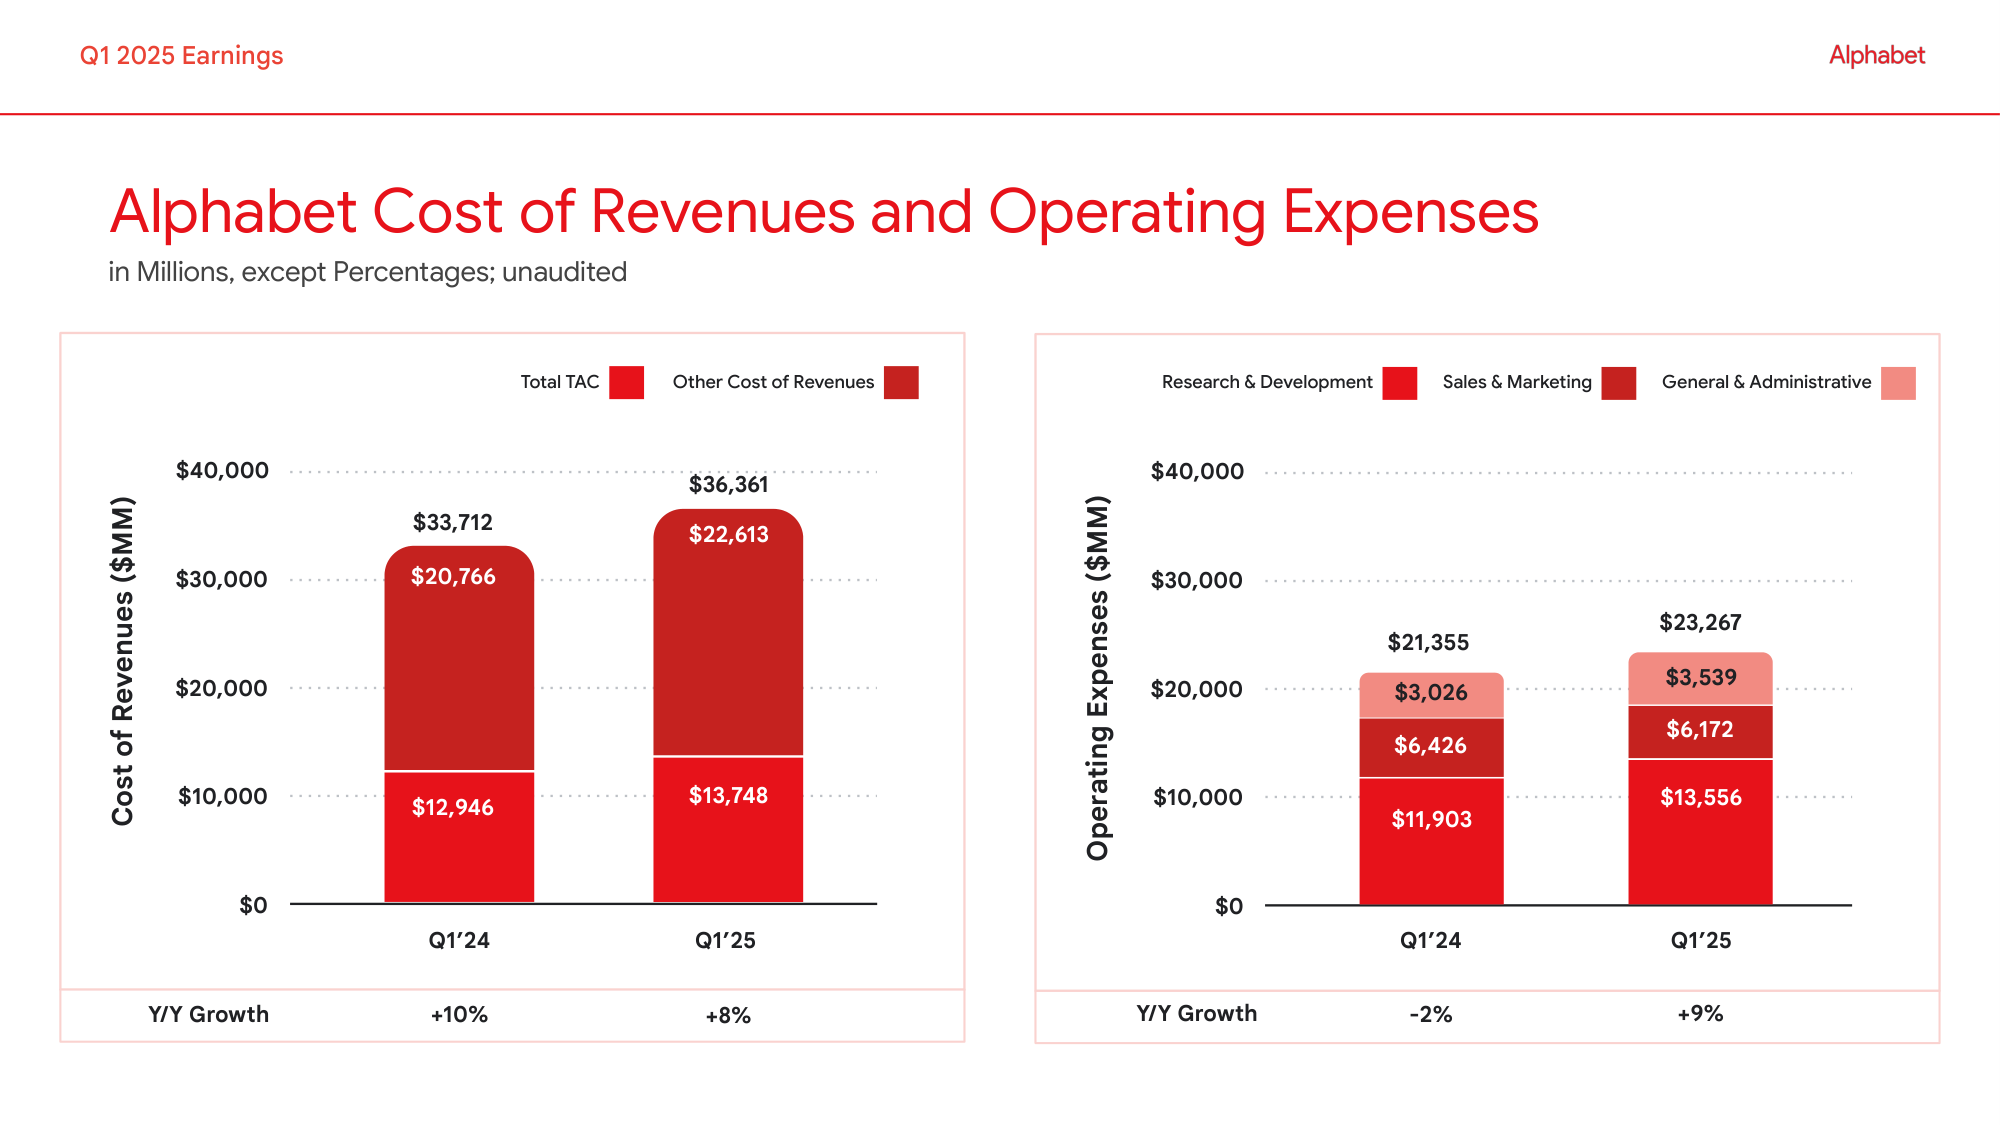

In [20]:
from PIL import Image
IMAGE_INDEX = "00-data/base/faiss_image_index"
IMAGE_META  = "00-data/base/faiss_image_metadata.json"

image_retriever = ImageRetriever(IMAGE_INDEX, IMAGE_META)
query = "What are the operating expenses?"
results = image_retriever.search(query, k=5)
results
path = results[0]["metadata"]["image_path"]
Image.open(path)


## Unified Agent Query Response

In [21]:
# from UnifiedCFOAgent import create_cfo_agent

# agent = create_cfo_agent()

# query = "Show Operating Expenses for the last 3 fiscal years, year-on-year comparison."

# # response = agent.invoke({"input": query})

# response = agent.invoke({"input": query}, return_intermediate_steps=True)

# print(response)


In [23]:
import os

print("Folders in sections:")
print(os.listdir("00-data/sections"))

print("\nFiles inside acquisitions folder:")
print(os.listdir("00-data/sections/acquisitions"))


Folders in sections:
['market_risk_disclosures', 'cover_page', 'controls_procedures', 'income_statement', 'signatures', 'financial_statements', 'legal_proceedings', 'mdna', 'summary_financial_data', 'exhibits', 'risk_factors', 'segment_info', 'balance_sheet', 'equity', 'cash_flow']

Files inside acquisitions folder:


FileNotFoundError: [Errno 2] No such file or directory: '00-data/sections/acquisitions'

In [24]:
from UnifiedCFOAgent import query_cfo_agent
question = "Show Operating Expenses for the last 3 fiscal years, year-on-year comparison."
response = query_cfo_agent(
    question,
    cache_threshold=0.85,
    use_cache=True
)

print(response["answer"])
print(response["metadata"])

Cache MISS

[INFO] Initializing FAISS indices from disk...
[TextSectionRetriever] Loaded 15 section indices from 00-data/sections

[PARALLEL] Starting parallel retrieval...
[RETRIEVE_IMAGE] Retrieved 5 images.

[TextSectionRetriever] Searching sections: ['income_statement', 'financial_statements', 'mdna', 'summary_financial_data']
[TextSectionRetriever] Using k=40 for query: 'Show Operating Expenses for the last 3 fiscal years, year-on-year comparison.'
[INFO] Searching 4 sections for: 'Retrieve "Operating Expenses" (also referred to as "SG&A", "Selling, General and Administrative Expenses", "Total Expenses", or "Operating Costs") for the last 3 fiscal years and provide a year-on-year comparison. Include results from both annual ("fiscal year", "year ended") and quarterly ("quarter ended") periods as reported in "Consolidated Statements of Income", "Statements of Operations", or similar financial statements. Search for all relevant synonyms and variations to ensure comprehensive covera

/Users/vanessatan/Documents/GitHub/PTO/UnifiedCFOAgent.py:225: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. For details, refer to the `LangGraph documentation <https://langchain-ai.github.io/langgraph/>`_ as well as guides for `Migrating from AgentExecutor <https://python.langchain.com/docs/how_to/migrate_agent/>`_ and LangGraph's `Pre-built ReAct agent <https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/>`_.
  agent = initialize_agent(


Question: Show Operating Expenses for the last 3 fiscal years, year-on-year comparison.
Thought: To provide the operating expenses for the last 3 fiscal years and a year-on-year comparison, I need to retrieve the financial tables that include operating expenses data.
Action: retrieve_table
Action Input: Operating Expenses last 3 fiscal years[RETRIEVE_TABLE] Completed table retrieval.


Observation: {"query": "Operating Expenses last 3 fiscal years", "answer": "To determine the operating expenses for the last three fiscal years, we will focus on the General and Administrative (G&A) expenses as provided in the retrieved data. The G&A expenses are a component of operating expenses.\n\n### General and Administrative Expenses for the Last Three Fiscal Years\n\n| Year | General and Administrative Expenses (in millions) | Source                  |\n|------|---------------------------------------------------|-------------------------|\n| 2021 | $13,510                                          

In [ ]:
question = "What is the operating expense for the last 3 fiscal years, year-on-year comparison."
response = query_cfo_agent(
    question,
    cache_threshold=0.85,
    use_cache=True
)

print(response["answer"])
print(response["metadata"])

In [ ]:
question = "Calculate the Operating Efficiency Ratio (Opex ÷ Operating Income) for the last 3 fiscal years, showing the working."
response = query_cfo_agent(
    question,
    cache_threshold=0.85,
    use_cache=True
)

print(response)

In [ ]:
question = "What are the operating expenses?"
response = query_cfo_agent(
    question,
    cache_threshold=0.85,
    use_cache=True
)

print(response)

In [ ]:
question = "Where can i get a graphic representation of the operating expenses?"
response = query_cfo_agent(
    question,
    cache_threshold=0.85,
    use_cache=True
)

print(response)

In [ ]:
from UnifiedCFOAgent import query_cfo_agent
question = "Summarize management's discussion about operating cost trends. Display any relevant images, text and tables."
response = query_cfo_agent(
    question,
    cache_threshold=0.85,
    use_cache=True
)

print(response["answer"])
print(response["metadata"])

In [ ]:
from UnifiedCFOAgent import query_cfo_agent
question = "Calculate the Operating Efficiency Ratio (Opex ÷ Operating Income) for the last 3 fiscal years, showing the working."
response = query_cfo_agent(
    question,
    cache_threshold=0.85,
    use_cache=True
)

print(response["answer"])
print(response["metadata"])

### RAG TRIAD + ACCURACY TESTING (van)

In [ ]:
import sys
sys.path.append("./RAG")


from run_rag import compute_manual_ctx, run_full_rag_benchmark

# ======================================= # Benchmark Queries # ======================================= 
benchmark_queries = [ 
                     { "id": "Q1", 
                      "name": "Gross Margin Trend", 
                      "query": "Report the Gross Margin (or Net Interest Margin, if a bank) over the last 5 quarters, with values." },
                     { "id": "Q2",
                      "name": "Operating Expenses YoY", 
                      "query": "Show Operating Expenses for the last 3 fiscal years, year-on-year comparison." }, 
                     { "id": "Q3", 
                      "name": "Operating Efficiency Ratio", 
                      "query": "Calculate the Operating Efficiency Ratio (Opex ÷ Operating Income) for the last 3 fiscal years, showing the working." 
                      } 
]


NameError: name 'run_rag' is not defined

In [ ]:
# must run before running the rag triad
manual_ctx = compute_manual_ctx(benchmark_queries)

In [78]:
df_results, df_answers = run_full_rag_benchmark(benchmark_queries, manual_ctx)

display(df_results)
display(df_answers)



📊 Q1 — Gross Margin Trend
[INFO] FAISS indices already initialized, reusing existing indices.
[TextSectionRetriever] Loaded 15 section indices from 00-data/sections

[PARALLEL] Starting parallel retrieval...
[RETRIEVE_IMAGE] Retrieved 5 images.

[TextSectionRetriever] Searching sections: ['income_statement', 'financial_statements']
[TextSectionRetriever] Using k=40 for query: 'Report the Gross Margin (or Net Interest Margin, if a bank) over the last 5 quarters, with values.'
[INFO] Searching 2 sections for: 'Retrieve the Gross Margin (also "gross profit margin", "gross profit", or "gross income margin")—or Net Interest Margin ("NIM", "net interest income margin") for banks—for the last 5 quarters ("quarter ended", "quarterly period", "interim period", "three months ended"). Include values as reported in "Consolidated Statements of Income", "Statements of Operations", or "Income Statement" sections of SEC filings (10-Q, 10-K). Also consider synonyms and related terms such as "fiscal qu

/Users/vanessatan/Documents/GitHub/PTO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/vanessatan/Documents/GitHub/PTO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/vanessatan/Documents/GitHub/PTO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/vanessatan/Documents/GitHub/PTO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/vanessatan/Documents/GitHub/PTO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/vanessatan/Documents/GitHub/PTO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  


📊 Q2 — Operating Expenses YoY
[INFO] FAISS indices already initialized, reusing existing indices.
[TextSectionRetriever] Loaded 15 section indices from 00-data/sections

[PARALLEL] Starting parallel retrieval...
[RETRIEVE_IMAGE] Retrieved 5 images.

[TextSectionRetriever] Searching sections: ['income_statement', 'financial_statements', 'mdna', 'summary_financial_data']
[TextSectionRetriever] Using k=40 for query: 'Show Operating Expenses for the last 3 fiscal years, year-on-year comparison.'
[INFO] Searching 4 sections for: 'Show operating expenses (also referred to as "SG&A", "selling, general and administrative expenses", "total expenses", or "operating costs") for the last 3 fiscal years, with year-over-year comparison. Include data from both annual and quarterly periods (e.g., "fiscal year", "year ended", "quarter ended") as reported in the "Consolidated Statements of Income", "Statements of Operations", or similar financial statements. Retrieve all relevant line items and synonym

/Users/vanessatan/Documents/GitHub/PTO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/vanessatan/Documents/GitHub/PTO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/vanessatan/Documents/GitHub/PTO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/vanessatan/Documents/GitHub/PTO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/vanessatan/Documents/GitHub/PTO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/vanessatan/Documents/GitHub/PTO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  


📊 Q3 — Operating Efficiency Ratio
[INFO] FAISS indices already initialized, reusing existing indices.
[TextSectionRetriever] Loaded 15 section indices from 00-data/sections

[PARALLEL] Starting parallel retrieval...
[RETRIEVE_IMAGE] Retrieved 5 images.

[TextSectionRetriever] Searching sections: ['income_statement']
[TextSectionRetriever] Using k=40 for query: 'Calculate the Operating Efficiency Ratio (Opex ÷ Operating Income) for the last 3 fiscal years, showing the working.'
[INFO] Searching 1 sections for: 'Retrieve data on operating expenses (also referred to as "Opex", "SG&A", "selling, general and administrative expenses", or "total operating expenses") and operating income (also called "income from operations" or "operating profit") from the Consolidated Statements of Income or Statements of Operations in SEC filings. Include figures for the last 3 fiscal years and, if available, for each quarter ("quarter ended", "quarterly period"). Use both annual ("fiscal year", "year ended

/Users/vanessatan/Documents/GitHub/PTO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/vanessatan/Documents/GitHub/PTO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/vanessatan/Documents/GitHub/PTO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/vanessatan/Documents/GitHub/PTO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/vanessatan/Documents/GitHub/PTO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/vanessatan/Documents/GitHub/PTO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  


📁 Saved logs:
 - 00-data/logs/rag/results_2025-11-28_11-02-40.json
 - 00-data/logs/rag/answers_2025-11-28_11-02-40.json


,Query ID,Query Name,Latency (s),Context Relevance (cosine),Context Relevance (LLM),Context Relevance (Merged),Answer Relevance (cosine),Answer Relevance (LLM),Answer Relevance (Merged),Faithfulness,Avg Triad (Merged),Num Logs,Log Files
0,Q1,Gross Margin Trend,44.49,0.325,0.1,0.213,0.649,0.9,0.775,0.765,0.584,1,[50]
1,Q2,Operating Expenses YoY,35.07,0.437,0.9,0.669,0.593,1.0,0.797,0.810,0.758,1,[51]
2,Q3,Operating Efficiency Ratio,49.88,0.369,0.8,0.584,0.815,1.0,0.907,0.893,0.795,1,[52]


,Query ID,Query Name,Full Answer,Sources
0,Q1,Gross Margin Trend,The Gross Margin over the last 5 quarters is a...,"{'sources': ['goog-10-q-q2-2025', 'goog-10-q-q..."
1,Q2,Operating Expenses YoY,### General and Administrative Expenses (in mi...,"{'sources': ['goog-10-k-2022', 'goog-10-q-q3-2..."
2,Q3,Operating Efficiency Ratio,Operating Efficiency Ratio (Opex ÷ Operating I...,"{'sources': ['goog-10-k-2022', 'goog-10-q-q3-2..."


John Testing 

Latency + Instrumentation Logs (plan to run more times to plot p50,p95, but need check if existing correct)

In [14]:
from UnifiedCFOAgent import query_cfo_agent
import time, statistics
import numpy as np
import pandas as pd
num_runs = 10
test_queries = [
    "Report the Gross Margin over the last 5 quarters, with values.",
    "Show Operating Expenses for the last 3 fiscal years, year-on-year comparison.",
    "Calculate the Operating Efficiency Ratio (Opex ÷ Operating Income) for the last 3 fiscal years, showing the working.",
]

run_summaries = []
detailed = []

for run in range(1, num_runs + 1):
    print(f"=== Run {run} ===")
    start_run = time.time()
    per_query_times = []

    for q in test_queries:
        q_start = time.time()
        # choose use_cache=True/False depending on test
        resp = query_cfo_agent(q, cache_threshold=0.85, use_cache=False)
        q_end = time.time()

        latency = q_end - q_start
        per_query_times.append(latency)
        detailed.append({"run": run, "query": q, "latency_s": latency})

    run_total = time.time() - start_run
    throughput_qps = len(test_queries) / run_total  # queries per second for this run

    run_summary = {
        "run": run,
        "run_total_s": run_total,
        "throughput_qps": throughput_qps,
        "avg_latency_s": statistics.mean(per_query_times),
        "p50_latency_s": np.percentile(per_query_times, 50),
        "p95_latency_s": np.percentile(per_query_times, 95),
    }
    run_summaries.append(run_summary)

    print("Run summary:", run_summary)

df_runs = pd.DataFrame(run_summaries)
df_details = pd.DataFrame(detailed) # individual runs take how long

display(df_runs)
display(df_details)

=== Run 1 ===
[INFO] FAISS indices already initialized, reusing existing indices.
[TextSectionRetriever] Loaded 15 section indices from 00-data\sections

[PARALLEL] Starting parallel retrieval...
[RETRIEVE_IMAGE] Retrieved 5 images.

[TextSectionRetriever] Searching sections: ['income_statement']
[TextSectionRetriever] Using k=40 for query: 'Report the Gross Margin over the last 5 quarters, with values.'
[INFO] Searching 1 sections for: 'Retrieve "Gross Margin", "Gross Profit", or "Gross Income" figures for the last 5 quarters ("quarter ended", "three months ended", "quarterly period") and include values. Search within "Consolidated Statements of Income", "Statements of Operations", or "Income Statement" sections. Also consider annual and interim filings (e.g., "fiscal year", "annual period") and related terms like "gross margin percentage", "gross profit ratio".'
[INFO] FAISS indices already initialized, reusing existing indices.
[INFO] Completed search across sections.
[RERANK] Top 5

KeyboardInterrupt: 

# Text Table Slide Ingestion t_ingest log

In [ ]:
# Table
from TableRetrieval.table_ingestion import stage1_extract_and_save
table_ingest_start = time.time()
stage1_extract_and_save()
stage2_create_embeddings(f"00-data/extracted_tables.json")
table_ingest_end = time.time() - table_ingest_start

# Slides
from ImageRetrieval.ImageRetrieval import ImageRetriever
from ImageRetrieval.slides_extractor import extract_slides_fitz
from ImageRetrieval.ocr_extractor import ocr_folder
from ImageRetrieval.image_faiss_builder import (
    create_image_embeddings,
    store_image_faiss,
    save_image_metadata
)

slides_ingest_start = time.time()
IMAGE_INDEX_PATH = "00-data/base/faiss_image_index"
IMAGE_META_PATH  = "00-data/base/faiss_image_metadata.json"

slide_docs = []

pdf_files = glob.glob("00-data/presentations/*.pdf")
print(f"[ImagePipeline] Found {len(pdf_files)} presentation PDFs.")

for pdf in pdf_files:
    pdf_name = os.path.splitext(os.path.basename(pdf))[0]
    out_dir = f"00-data/presentations/slides_{pdf_name}"

    extract_slides_fitz(pdf, out_dir)
    slide_docs.extend(ocr_folder(out_dir, label=pdf_name))

print(f"[ImagePipeline] Total OCR slide documents: {len(slide_docs)}")

# Embed
embeddings = create_image_embeddings(slide_docs)

# FAISS + metadata
store_image_faiss(embeddings, IMAGE_INDEX_PATH)
save_image_metadata(slide_docs, IMAGE_META_PATH)
slides_ingest_end = time.time() - slides_ingest_start

# Text
from TextRetrieval.TextExtractor import extract_text_from_pdf
text_ingest_end = time.time()
extract_text_from_pdf(); 

from TextRetrieval.TextFaissBuilder import create_chunks, built_indices

chunks = create_chunks();
built_indices(chunks); 
text_ingest_end = time.time() - text_ingest_end

print("Ingestion Timing Results")
print(f"Table Ingestion Time: {table_ingest_end} seconds")
print(f"Text Ingestion Time: {text_ingest_end} seconds")
print(f"Slides Ingestion Time: {slides_ingest_end} seconds")

STAGE 1: EXTRACTING TABLES FROM PDFs


annuals: 3 files
  Processing: 00-data/annuals\goog-10-k-2022.pdf
    → Extracted 76 tables
  Processing: 00-data/annuals\goog-10-k-2023-final.pdf
    → Extracted 69 tables
  Processing: 00-data/annuals\goog-10-k-2024.pdf
    → Extracted 69 tables

quarterlies: 11 files
  Processing: 00-data/quarterlies\goog-10-q-q1-2022.pdf
    → Extracted 66 tables
  Processing: 00-data/quarterlies\goog-10-q-q1-2023.pdf
    → Extracted 70 tables
  Processing: 00-data/quarterlies\goog-10-q-q1-2024.pdf
    → Extracted 65 tables
  Processing: 00-data/quarterlies\goog-10-q-q1-2025.pdf
    → Extracted 78 tables
  Processing: 00-data/quarterlies\goog-10-q-q2-2022.pdf
    → Extracted 71 tables
  Processing: 00-data/quarterlies\goog-10-q-q2-2023.pdf
    → Extracted 75 tables
  Processing: 00-data/quarterlies\goog-10-q-q2-2024.pdf
    → Extracted 81 tables
  Processing: 00-data/quarterlies\goog-10-q-q2-2025.pdf
    → Extracted 86 tables
  Processing: 00-data/quarterlies\

## 8. Results & Plots

Show baseline vs optimized. Include latency plots (p50/p95) and accuracy tables.

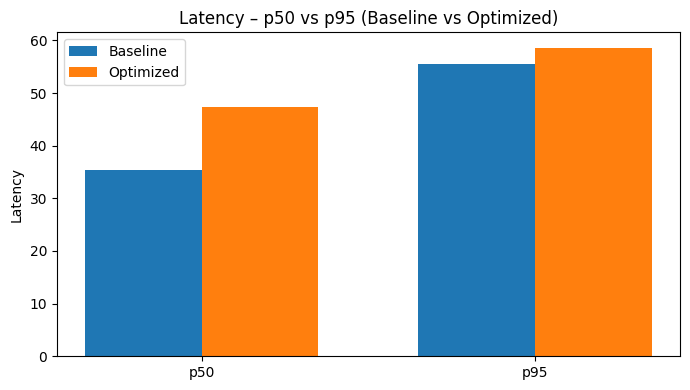

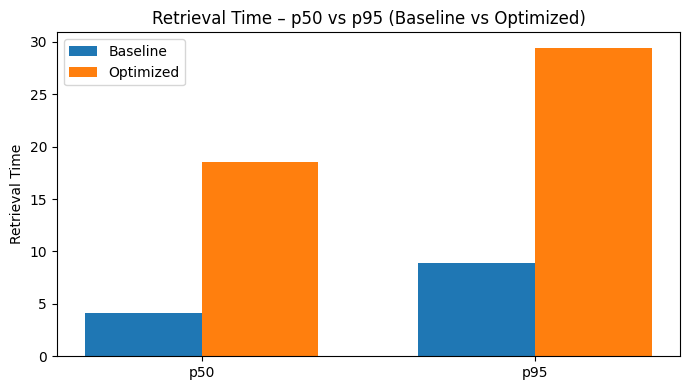

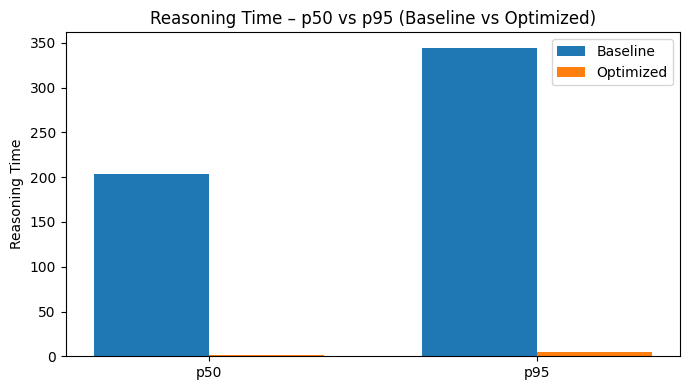

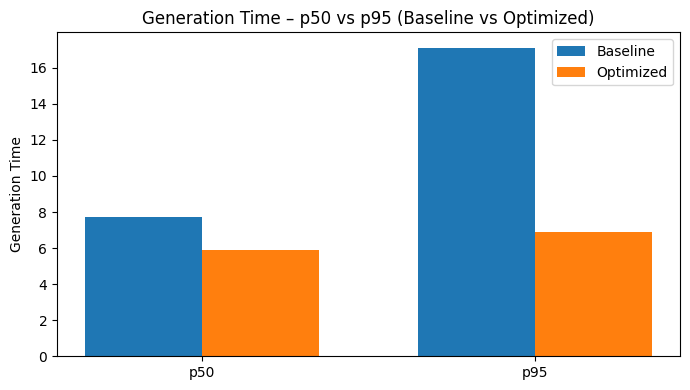

In [ ]:
# TODO: Generate plots with matplotlib
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def load_runs(path):
    runs = []
    for file in glob.glob(path):
        with open(file, "r") as f:
            runs.append(json.load(f))
    return pd.DataFrame(runs)

# Load both sets (baseline using part1 codes)
df_baseline = load_runs("00-data/logs/instru_log_testings/baseline/*.json")
df_optimized = load_runs("00-data/logs/instru_log_testings/*.json")

def expand_callback_columns(df):
    df["reasoning_time"] = df["callback_summary"].apply(lambda x: x["reasoning_time"])
    df["generation_time"] = df["callback_summary"].apply(lambda x: x["generation_time"])
    return df

df_baseline = expand_callback_columns(df_baseline)
df_optimized = expand_callback_columns(df_optimized)
df_baseline["retrieval_time"] = df_baseline["callback_summary"].apply(lambda x: x["retrieval_time"])
# metrics = ["latency", "retrieval_time", "reasoning_time", "generation_time"]
metrics = ["latency", "retrieval_time","reasoning_time", "generation_time"]

for metric in metrics:
    # Compute p50 and p95
    baseline_p50 = df_baseline[metric].quantile(0.50)
    baseline_p95 = df_baseline[metric].quantile(0.95)

    optimized_p50 = df_optimized[metric].quantile(0.50)
    optimized_p95 = df_optimized[metric].quantile(0.95)

    # Create chart
    plt.figure(figsize=(7, 4))

    labels = ["p50", "p95"]
    baseline_values = [baseline_p50, baseline_p95]
    optimized_values = [optimized_p50, optimized_p95]

    x = np.arange(len(labels))       # [0, 1]
    width = 0.35

    plt.bar(x - width/2, baseline_values, width, label="Baseline")
    plt.bar(x + width/2, optimized_values, width, label="Optimized")

    plt.xticks(x, labels)
    plt.ylabel(metric.replace("_", " ").title())
    plt.title(f"{metric.replace('_', ' ').title()} – p50 vs p95 (Baseline vs Optimized)")
    plt.legend()
    plt.tight_layout()
    plt.show()


